In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
print(Measurement.__dict__)

{'__table__': Table('measurement', MetaData(bind=None), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None), '__module__': 'sqlalchemy.ext.automap', '__doc__': None, '_sa_class_manager': <ClassManager of <class 'sqlalchemy.ext.automap.measurement'> at 2205a5022b0>, '__init__': <function __init__ at 0x000002205A4C9B70>, 'id': <sqlalchemy.orm.attributes.InstrumentedAttribute object at 0x000002205A5023B8>, 'station': <sqlalchemy.orm.attributes.InstrumentedAttribute object at 0x000002205A502468>, 'date': <sqlalchemy.orm.attributes.InstrumentedAttribute object at 0x000002205A502518>, 'prcp': <sqlalchemy.orm.attributes.InstrumentedAttribute object at 0x000002205A5025C8>, 'tobs': <sqlalchemy.orm.attributes.InstrumentedAttribute object at 0x000002205A502678>, '__mapper__'

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Explore Measurement Database
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [12]:
# Explore Station Database
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

## Precipitation Analysis

In [13]:
# Find the latest date record 
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [14]:
# Calculate the date 1 year ago from the last data point in the database
a_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
a_year_ago

datetime.date(2016, 8, 23)

In [33]:
# Design a query to retrieve the last 12 months of precipitation data 
precipitation = session.query(Measurement.date, Measurement.prcp).\
                            filter(Measurement.date >= a_year_ago).\
                            order_by(Measurement.date.asc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precipitation, columns=['Date', 'Precipitation'])
df.set_index('Date', inplace=True)
df.head(10)

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,0.08
2016-08-24,2.15


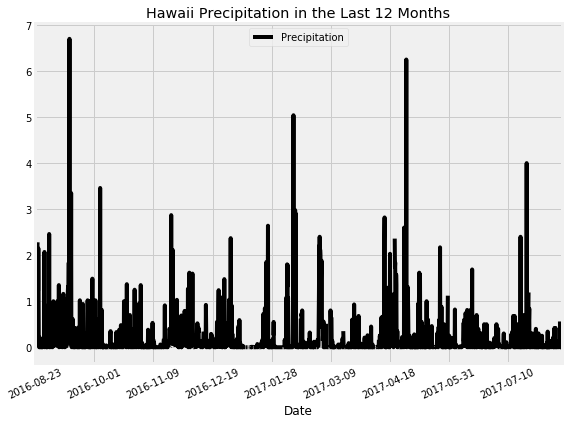

In [34]:
# Plot the results of the last 12 months of precepitation data
df.plot(title='Hawaii Precipitation in the Last 12 Months', color='black', figsize=(8,6))
plt.legend(loc='upper center')
plt.xticks(rotation=25)
plt.tight_layout()
plt.savefig("Images/precipitation_histogram.png")
plt.show()

In [35]:
# Calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [36]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Station.station).distinct().count()
print(f'There are a total of {num_stations} stations.')

There are a total of 9 stations.


In [37]:
# List all stations 
all_stations = session.query(Station.station, Station.name).group_by(Station.station).all()
all_stations

[('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00513117', 'KANEOHE 838.1, HI US'),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US'),
 ('USC00517948', 'PEARL CITY, HI US'),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US'),
 ('USC00519281', 'WAIHEE 837.5, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US')]

In [38]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(Measurement.station, func.count(Measurement.station)).\
                         group_by(Measurement.station).\
                         order_by(func.count(Measurement.station).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [39]:
# Station with the highest number of observations
most_active = stations[0][0]
num_observations = stations[0][1]
print(f'The most active is station is {most_active} with {num_observations} observations.')

The most active is station is USC00519281 with 2772 observations.


In [40]:
# Using the station id from the previous query, calculate:  
# the lowest, highest and average temperature recorded from the most active station
lowest_temp = session.query(Measurement.station, func.min(Measurement.tobs)).\
                            filter(Measurement.station == most_active).all()

highest_temp = session.query(Measurement.station, func.max(Measurement.tobs)).\
                            filter(Measurement.station == most_active).all()

average_temp = session.query(Measurement.station,func.avg(Measurement.tobs)).\
                            filter(Measurement.station == most_active).all()

# Diplay the results
print(f'From the most active station {most_active}:')
print(f' - The lowest temperature is {lowest_temp[0][1]}')
print(f' - The highest temperature is {highest_temp[0][1]}')
print(f' - The average temperature is {round(average_temp[0][1],1)}')

From the most active station USC00519281:
 - The lowest temperature is 54.0
 - The highest temperature is 85.0
 - The average temperature is 71.7


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 
temperature = session.query(Measurement.tobs).\
                    filter(Measurement.station == most_active).\
                    filter(Measurement.date >= a_year_ago).\
                    order_by(Measurement.date.asc()).all()

temp_df = pd.DataFrame(temperature, columns=['Temperature'])
temp_df.head()

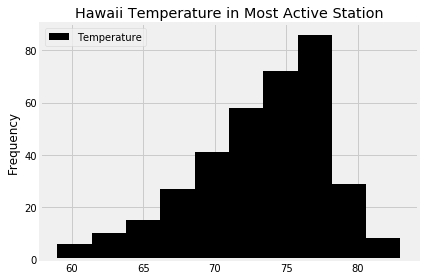

In [29]:
# Plot the results
temp_df.plot.hist(title='Hawaii Temperature in Most Active Station', color='black')
plt.tight_layout()
plt.savefig("Images/most_active_station_histogram.png")
plt.show()

## Temperature Analysis II

In [30]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [31]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip = calc_temps('2017-05-12','2017-05-20')
my_trip

[(68.0, 74.82, 79.0)]

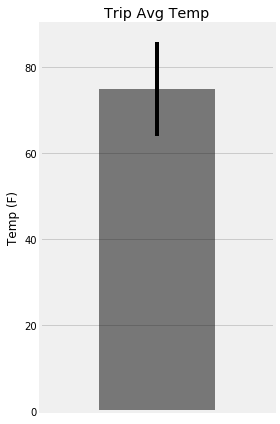

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
my_trip_df = pd.DataFrame(my_trip, columns=['tmin', 'tavg', 'tmax'])
my_trip_df.plot.bar(y='tavg', yerr=(my_trip_df['tmax'] - my_trip_df['tmin']), title='Trip Avg Temp', color='black', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel('Temp (F)')
plt.gca().legend_.remove()
plt.tight_layout()
plt.savefig("Images/trip_avg_temp.png")
plt.show()

In [96]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precipitation(start_date, end_date):

    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).\
            filter(Measurement.date >= start_date).\
            filter(Measurement.date <= end_date).\
            group_by(Measurement.station).\
            order_by(Measurement.prcp.desc()).all()

print(precipitation('2017-05-12','2017-05-20'))

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.04), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.02), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, None)]
